In [82]:
using PyPlot
using Random

In [165]:
struct Controls
    reduce::Array{Float64,1}
    remove::Array{Float64,1}
    geoeng::Array{Float64,1}
    adapt::Array{Float64,1}
end

struct Economics
    β::Float64
    utility_discount_rate::Float64
    reduce_cost::Float64
    remove_cost::Float64
    geoeng_cost::Float64
    adapt_cost::Float64
end


# economic parameters
β = 1.; # damage parameter (10^12 $ / C^2)
utility_discount_rate = 0.014 #2 # utility discount rate
GWP = 100. # Global World Product (10^12 $/yr)
Economics() = Economics(
    β, utility_discount_rate,
    0.05*GWP, 0.05*GWP, 0.25*GWP, 0.15*GWP
)

nondim_linear(t::Array) = (t .- t[1])/(t[end] - t[1]);

function init_linear_controls(t)
    c = Controls(
        nondim_linear(t)/3.,
        nondim_linear(t)/2.,
        nondim_linear(t)/8.,
        nondim_linear(t)/10.
    )
    return c
end

struct ClimateModel
    name::String
    ECS::Float64
    domain::Array{Float64,1}
    controls::Controls
    economics::Economics
    CO₂_init::Float64
    δT_pre::Float64
    
    ϵ::Float64
    
    function ClimateModel(name, ECS, domain, controls, economics, CO₂_init, δT_pre)
        
        ϵ = ECS/log(2.); # Transient Warming Parameter
        
        return new(
            name, ECS, domain, controls, economics, CO₂_init, δT_pre,
            ϵ)
    end
end

ClimateModel(name, ECS, domain, controls, economics) = ClimateModel(name, ECS, domain, controls, economics, 415., 1.1)

f_low(α::Array) = (α ./ (1. .+ α)).^2 # shape of individual cost functions
f_med(α::Array) = α.^2 # shape of individual cost functions
f_high(α::Array) = (α ./ (1. .- α)).^2 # shape of individual cost functions


f_high (generic function with 1 method)

In [166]:
function baseline_emissions(t::Array{Float64,1})
    q = 5. .* ones(size(t)); # emissions scenario
    q[40:81] .= q[1] * (40. .-(0.:1.:41.))/40.
    q[81:end] .= 0.
    return q
end

CO₂_baseline(model::ClimateModel) = model.CO₂_init .+ cumsum(baseline_emissions(model.domain))

CO₂(model::ClimateModel) = (
    CO₂_baseline(model) .-
    cumsum(baseline_emissions(model.domain) .* model.controls.reduce) .-
    cumsum(baseline_emissions(model.domain)[1] .* model.controls.remove)
);

δT_baseline(model::ClimateModel) = (
        model.δT_pre .+
        model.ϵ .* log.( CO₂_baseline(model)./ model.CO₂_init )
)

δT(model::ClimateModel) = (
    (
        model.δT_pre .+
        model.ϵ .* log.( CO₂(model)./ model.CO₂_init )
        ) .* (1. .- model.controls.geoeng).^2
)

damage_cost_baseline(model::ClimateModel) = (
    model.economics.β .* δT_baseline(model).^2
)

damage_cost(model::ClimateModel) = (
    (1. .- model.controls.adapt) .*
    model.economics.β .* δT(model).^2
)

control_cost(model::ClimateModel) = (
    model.economics.reduce_cost .* f_med(model.controls.reduce) .+
    model.economics.remove_cost .* f_med(model.controls.remove) .+
    model.economics.geoeng_cost .* f_med(model.controls.geoeng) .+
    model.economics.adapt_cost .* f_med(model.controls.adapt)
)

discounting(economics::Economics, t::Array{Float64,1}) = (1. .+ economics.utility_discount_rate) .^ (-(t .- t[1]))

net_cost(model::ClimateModel) = (
    damage_cost(model) .+ control_cost(model)
)

total_cost(model::ClimateModel) = (
    sum(net_cost(model))
)

total_cost_constrained(model::ClimateModel) = (
    total_cost(model) +
    200. * (
        sum(diff(model.controls.reduce).^2) +
        sum(diff(model.controls.remove).^2) +
        sum(diff(model.controls.geoeng).^2) +
        sum(diff(model.controls.adapt).^2)
    ) +
    500. * (
        model.controls.reduce[1].^2 .+
        model.controls.remove[1].^2 .+
        model.controls.geoeng[1].^2 .+
        model.controls.adapt[1].^2
    )
)

discounted_total_cost(model::ClimateModel) = (
    sum(net_cost(model) .* discounting(model.economics, t))
)

discounted_total_cost_constrained(model::ClimateModel) = (
    discounted_total_cost(model) +
    200. * (
        sum(diff(model.controls.reduce).^2) +
        sum(diff(model.controls.remove).^2) +
        sum(diff(model.controls.geoeng).^2) +
        sum(diff(model.controls.adapt).^2)
    ) +
    500. * (
        model.controls.reduce[1].^2 .+
        model.controls.remove[1].^2 .+
        model.controls.geoeng[1].^2 .+
        model.controls.adapt[1].^2
    )
)

function perturbed_model(model::ClimateModel, controlname::Symbol, time_idx::Int, Δcontrol::Float64)
    perturbed_controls = Controls(
        deepcopy(model.controls.reduce),
        deepcopy(model.controls.remove),
        deepcopy(model.controls.geoeng),
        deepcopy(model.controls.adapt)
    )
    getfield(perturbed_controls, controlname)[time_idx] = getfield(perturbed_controls, controlname)[time_idx] + Δcontrol
    return ClimateModel(model.name, model.ECS, model.domain, perturbed_controls, model.economics, model.CO₂_init, model.δT_pre)
end

perturbed_model (generic function with 1 method)

In [167]:
function ∇cost(model::ClimateModel)
    Δcontrol = 1.e-6
    ∇ = zeros((length(model.domain), length(fieldnames(Controls))))
    for (control_idx, controlname) in enumerate(fieldnames(Controls))
        for time_idx in 1:length(model.domain)
            ∇[time_idx,control_idx] = ((
                    discounted_total_cost_constrained(perturbed_model(model, controlname, time_idx, Δcontrol)) -
                    discounted_total_cost_constrained(model))
                / Δcontrol
            )
        end
    end
    
    return ∇
end

function is_converged(∇, tolerance)
    print(sum(∇.^2), " ")
    return sum(∇.^2) < tolerance
end

is_converged (generic function with 1 method)

In [168]:
function optimize!(model::ClimateModel, tolerance=1.e-6)
    ∇ = ∇cost(model)
    previous_update_vector = zeros(size(∇))
    
    iterations = 0
    while !is_converged(∇, tolerance)
        ∇ = ∇cost(model)
        learning_rate = 1.e-3
        momentum_fraction = 0.9
        update_vector = (
            ∇ .* learning_rate + 
            previous_update_vector .* momentum_fraction
        )
        
        for (control_idx, controlname) in enumerate(fieldnames(Controls))
            getfield(model.controls, controlname) .-= (
                update_vector[:,control_idx]
            )
        end
        
        previous_update_vector = copy(update_vector)

        if iterations>400
            break
        else
            iterations+=1
        end
        
    end
    print("Converged after $iterations iterations.\n")
end

optimize! (generic function with 2 methods)

In [169]:
function plot_setup(model::ClimateModel)

    figure(figsize=(8,4))
    subplot(1,2,1)
    plot(model.domain, baseline_emissions(model.domain))
    ylabel(L"CO₂ emissions $q$ (ppm / yr)")
    xlabel("year")
    title("baseline emissions")
    annotate(s="a)",xy=(0,1.02),xycoords="axes fraction",fontsize=12)

    subplot(1,2,2)
    plot(model.domain, 1. .-discounting(model.economics, model.domain))
    plot(model.domain, ones(size(model.domain)), "r--")
    xlabel("year")
    ylabel("fraction of cost discounted")
    xlim(t[1],t[end])
    ylim(0,1.05)
    annotate(s="c)",xy=(0,1.02),xycoords="axes fraction",fontsize=12)

    tight_layout()

    savefig("figures/model_setup.png", bbox_inches="tight", dpi=100)
end

function plot_state(model::ClimateModel)
    figure(figsize=(10,8))
    subplot(2,2,1)
    plot(model.domain, model.controls.remove, label=L"$\phi$ (negative emissions)")
    plot(model.domain, model.controls.reduce, label=L"$\varphi$ (emissions reductions)")
    plot(model.domain, model.controls.adapt, label=L"$\chi$ (adaptation)")
    plot(model.domain, model.controls.geoeng, label=L"$\lambda$ (geoengineering)")
    ylabel(L"fraction of control technology deployed $\alpha$")
    xlabel("year")
    title("optimized control deployments")
    legend()
    annotate(s="a)",xy=(0,1.02),xycoords="axes fraction",fontsize=12)


    subplot(2,2,2)
    plot(model.domain,CO₂(model), label=L"$c_{\phi,\varphi}(t)$")
    plot(model.domain,CO₂_baseline(model), label=L"$c_{0}(t)$")
    legend()
    ylabel(L"CO₂ concentration $c$ (ppm)")
    xlabel("year")
    title("concentrations scenarios")
    annotate(s="b)",xy=(0,1.02),xycoords="axes fraction",fontsize=12)

    subplot(2,2,3)
    plot(model.domain,δT(model), label=L"$\delta T_{\varphi,\phi}$ (controlled)")
    plot(model.domain,δT_baseline(model), label=L"$\delta T_{0}$ (baseline)")
    plot(model.domain,2.0.*ones(size(model.domain)),"k--", label="Paris Goal")
    ylabel(L"warming $δT$ ($^{\circ}$C)")
    xlabel("year")
    ylim([0,4.0])
    legend()
    title("warming since 1850")
    annotate(s="c)",xy=(0,1.02),xycoords="axes fraction",fontsize=12)

    subplot(2,2,4)
    plot(model.domain, net_cost(model) .* discounting(model.economics, model.domain), label="total (controlled) cost")
    plot(model.domain, control_cost(model) .* discounting(model.economics, model.domain), label="cost of controls")
    plot(model.domain, damage_cost(model) .* discounting(model.economics, model.domain), label="controlled damages")
    plot(model.domain, damage_cost_baseline(model) .* discounting(model.economics, model.domain), label="uncontrolled damages")
    ylabel(L"discounted costs (10$^{12}$ \$)")
    xlabel("year")
    legend()
    annotate(s="d)",xy=(0,1.02),xycoords="axes fraction",fontsize=12)

    tight_layout()

    savefig("figures/model_state.png", bbox_inches="tight", dpi=100)
end

plot_state (generic function with 1 method)

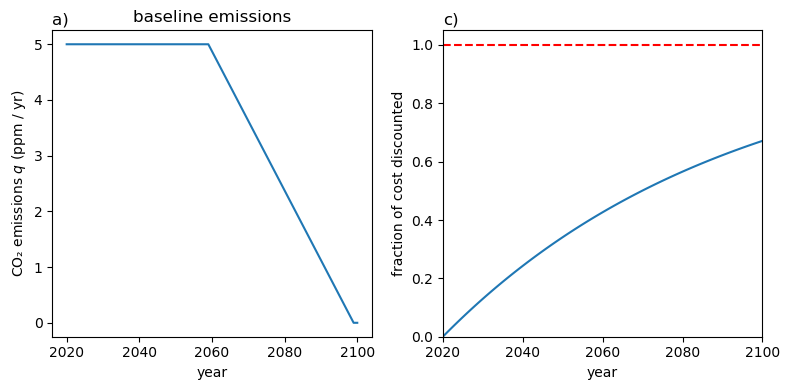

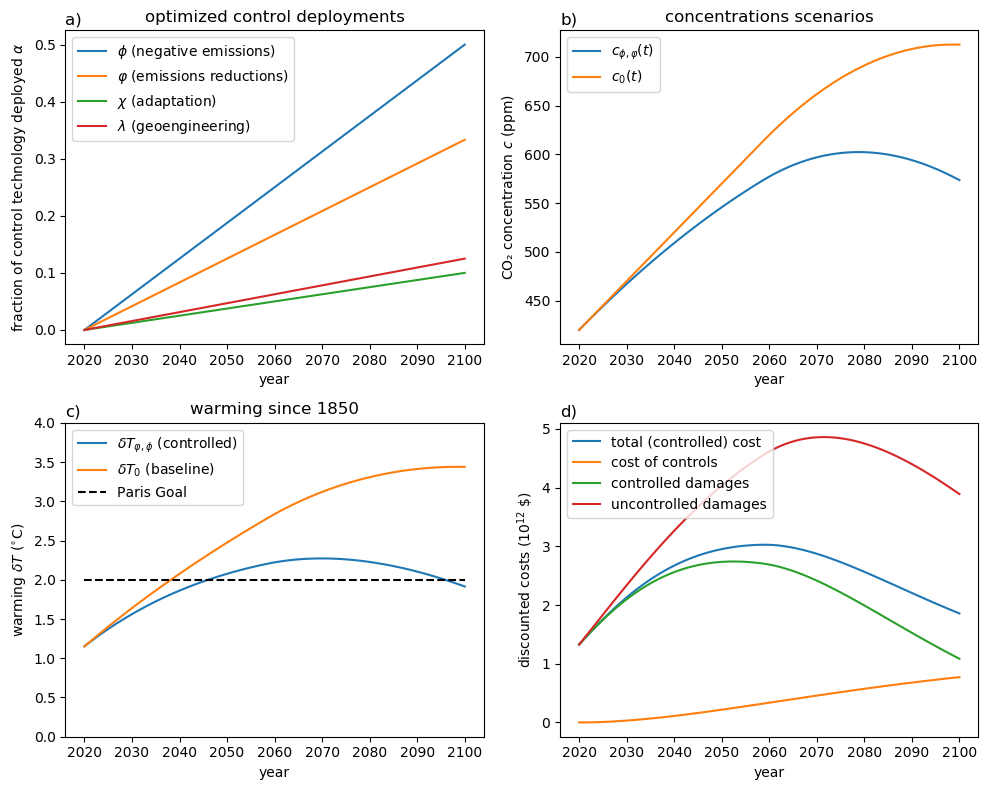

In [170]:
name = "test";
ECS = 3.0;
t = Array(2020:1.:2100);
economics = Economics()
controls = init_linear_controls(t);

model = ClimateModel(name, ECS, t, controls, economics);
plot_setup(model)
plot_state(model)

In [171]:
optimize!(model)

6652.028957019665 6652.028957019665 5608.997571171682 4224.654881190518 2659.340475247559 1492.7425245407583 654.9917191230454 353.7350467516588 310.36336328904486 546.701956194817 801.5081069551187 1076.0372510286645 1228.8467256960287 1283.2511868345207 1213.332896980136 1052.4678386657001 845.6383600340296 612.6851359296852 419.73397153622165 256.59107850351523 174.54607999898965 133.26650841490965 156.8383379194115 192.21050247233677 246.47894048634438 278.9600446561235 295.8747863172248 282.8407606996128 250.36273734250724 205.06629766363613 154.91956718625184 113.04891053709007 78.21772010095927 60.26858156304005 49.78592520463214 51.84685628337626 54.92272092379026 61.88125855512803 64.48870905148955 65.31397994568243 61.19989878593498 54.47534669611302 45.85806947112358 36.5006956835869 28.695853198601245 21.835957520383108 18.05154321723146 15.34201429770311 15.081555716220757 14.922495890124214 15.680246029677829 15.660720289429257 15.436600145113177 14.366933395562164 12.845

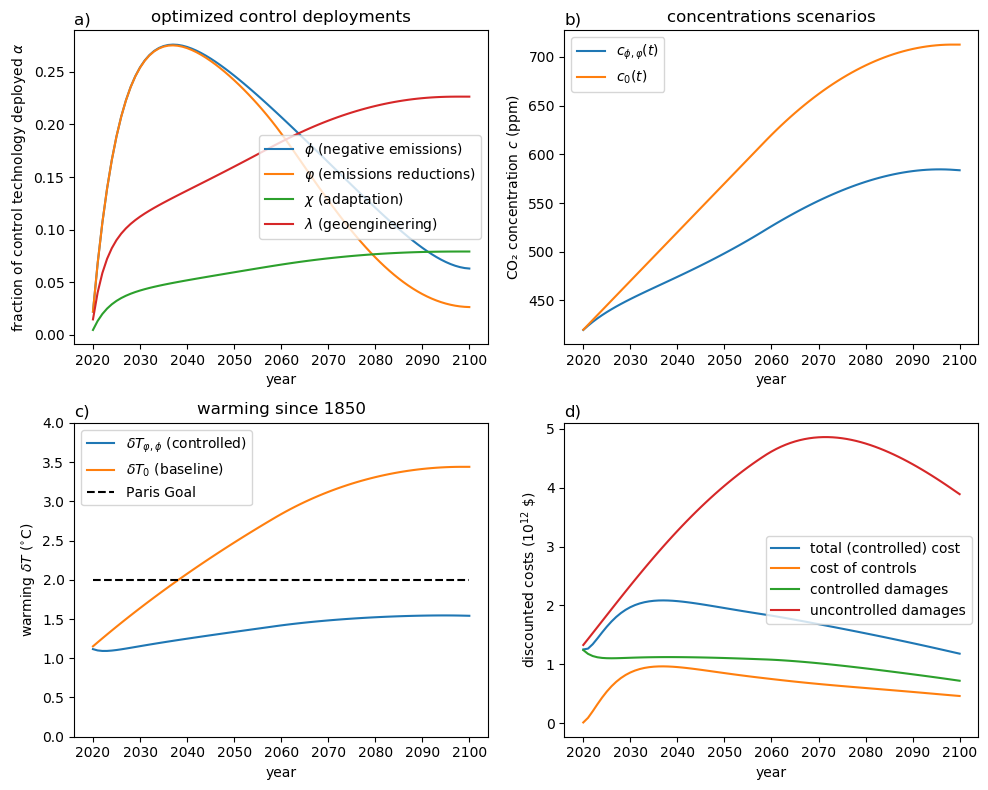

In [172]:
plot_state(model)